In [1]:
#import necessary packages for project

#openmeteo is an open source api for weather data
import openmeteo_requests

import datetime as dt
import os
import glob
import requests_cache
import pandas as pd
from retry_requests import retry

C:\Users\ALL2429\AppData\Local\Temp\ipykernel_25188\1024095106.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [16]:

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 39.6295,
	"longitude": -79.9559,
	"hourly": ["temperature_2m", "precipitation"],
	"daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch",
	"timezone": "America/New_York",
	"past_days": 92,
	"forecast_days": 16
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["precipitation_sum"] = daily_precipitation_sum

api_weather = pd.DataFrame(data = daily_data)
api_weather

Coordinates 39.641422271728516°N -79.95689392089844°E
Elevation 271.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s
                          date  temperature_2m  precipitation
0    2024-07-23 04:00:00+00:00       63.434303            0.0
1    2024-07-23 05:00:00+00:00       63.254299            0.0
2    2024-07-23 06:00:00+00:00       62.894299            0.0
3    2024-07-23 07:00:00+00:00       62.534302            0.0
4    2024-07-23 08:00:00+00:00       62.174301            0.0
...                        ...             ...            ...
2587 2024-11-07 23:00:00+00:00       56.684299            0.0
2588 2024-11-08 00:00:00+00:00       53.624302            0.0
2589 2024-11-08 01:00:00+00:00       52.274300            0.0
2590 2024-11-08 02:00:00+00:00       51.734299            0.0
2591 2024-11-08 03:00:00+00:00       51.374302            0.0

[2592 rows x 3 columns]


,date,temperature_2m_max,temperature_2m_min,precipitation_sum
0,2024-07-23 04:00:00+00:00,84.134300,61.634300,0.007874
1,2024-07-24 04:00:00+00:00,85.394302,65.594299,0.263780
2,2024-07-25 04:00:00+00:00,85.034302,63.254299,0.291339
3,2024-07-26 04:00:00+00:00,83.774300,58.034298,0.000000
4,2024-07-27 04:00:00+00:00,88.177101,56.954300,0.000000
...,...,...,...,...
103,2024-11-03 04:00:00+00:00,65.144302,38.684299,0.000000
104,2024-11-04 04:00:00+00:00,65.594299,37.784302,0.000000
105,2024-11-05 04:00:00+00:00,65.324303,37.244301,0.000000
106,2024-11-06 04:00:00+00:00,64.964302,41.294300,0.000000


In [3]:
path = os.getcwd()
print(path)

c:\Users\ALL2429\source_repos\ML_Gas_Analysis


In [4]:
#Import file for daily burns from customer (**NOTE: data has been randomized for )
reported_burns = pd.read_excel(str(path) + "\Ridgway_Randomized_Data.xlsx")
prev_weather = pd.read_excel(str(path) + "\HDD_WV.xlsx")



In [14]:
#Remove Unwanted Columns from Reported Burns
reported_burns1 =reported_burns.drop('Unnamed: 0', axis=1)
#reported_burns["Date"].dtype
reported_burns1['Date']

0     2023-01-01
1     2023-01-02
2     2023-01-03
3     2023-01-04
4     2023-01-05
         ...    
695   2024-11-26
696   2024-11-27
697   2024-11-28
698   2024-11-29
699   2024-11-30
Name: Date, Length: 700, dtype: datetime64[ns]

In [6]:
#Remove unwatned columns from prev_weather
prev_weather1 = prev_weather.iloc[:, :3]
#prev_weather1

In [37]:
#Remove timezones so dt and merge on dt
#pd.to_datetime(api_weather['date']).dt.tz_localize(None)
api_weather['date'] = pd.to_datetime(api_weather['date'].dt.date)
api_weather['date']
api_weather

,date,temperature_2m_max,temperature_2m_min,precipitation_sum
0,2024-07-23,84.134300,61.634300,0.007874
1,2024-07-24,85.394302,65.594299,0.263780
2,2024-07-25,85.034302,63.254299,0.291339
3,2024-07-26,83.774300,58.034298,0.000000
4,2024-07-27,88.177101,56.954300,0.000000
...,...,...,...,...
103,2024-11-03,65.144302,38.684299,0.000000
104,2024-11-04,65.594299,37.784302,0.000000
105,2024-11-05,65.324303,37.244301,0.000000
106,2024-11-06,64.964302,41.294300,0.000000


In [46]:
#Combine all the dfs
df1 = pd.merge(reported_burns1, api_weather, how = 'left', left_on='Date', right_on='date')
df_final = pd.merge(df1, prev_weather1, how='left', on = 'Date')
df_final 
#ddf1f_test

,Date,Randomized Total Nom,Randomized Reported Burn,date,temperature_2m_max,temperature_2m_min,precipitation_sum,NOAA Temp High,NOAA Temp Low
0,2023-01-01,6287.430371,5624.479859,NaT,NaN,NaN,NaN,59,49
1,2023-01-02,6031.587336,4954.683237,NaT,NaN,NaN,NaN,65,54
2,2023-01-03,3321.416004,2093.128369,NaT,NaN,NaN,NaN,68,59
3,2023-01-04,6382.194807,3131.200413,NaT,NaN,NaN,NaN,69,42
4,2023-01-05,6595.220969,5008.043738,NaT,NaN,NaN,NaN,51,39
...,...,...,...,...,...,...,...,...,...
695,2024-11-26,1151.347315,1467.682839,NaT,NaN,NaN,NaN,57,41
696,2024-11-27,1187.827413,1514.185935,NaT,NaN,NaN,NaN,58,36
697,2024-11-28,1181.022544,1505.511411,NaT,NaN,NaN,NaN,46,34
698,2024-11-29,928.009777,1182.982761,NaT,NaN,NaN,NaN,49,32


In [48]:
df_final[df_final['temperature_2m_max'].notna()]

,Date,Randomized Total Nom,Randomized Reported Burn,date,temperature_2m_max,temperature_2m_min,precipitation_sum,NOAA Temp High,NOAA Temp Low
569,2024-07-23,212.791880,405.463037,2024-07-23,84.134300,61.634300,0.007874,81,69
570,2024-07-24,246.579901,500.225129,2024-07-24,85.394302,65.594299,0.263780,82,66
571,2024-07-25,274.254874,518.648186,2024-07-25,85.034302,63.254299,0.291339,85,63
572,2024-07-26,323.043329,609.987261,2024-07-26,83.774300,58.034298,0.000000,83,59
573,2024-07-27,229.053211,445.636476,2024-07-27,88.177101,56.954300,0.000000,88,60
...,...,...,...,...,...,...,...,...,...
672,2024-11-03,1186.603150,1512.625303,2024-11-03,65.144302,38.684299,0.000000,67,38
673,2024-11-04,1293.794532,1649.267782,2024-11-04,65.594299,37.784302,0.000000,52,31
674,2024-11-05,1575.062717,2007.815098,2024-11-05,65.324303,37.244301,0.000000,53,32
675,2024-11-06,1160.546185,1479.409122,2024-11-06,64.964302,41.294300,0.000000,56,38


In [58]:
#If the api did not have temperature data, fill in with the temperature we have
df_final['temperature_2m_max'] = df_final['temperature_2m_max'].fillna(df_final['NOAA Temp High'])
df_final['temperature_2m_min'] = df_final['temperature_2m_min'].fillna(df_final['NOAA Temp Low'])
#df_final[df_final['Date'] == '2024-11-01']

In [67]:
#Drop the temperature columns we used to fill in data with
df = df_final.drop(['NOAA Temp High','NOAA Temp Low', 'date'], axis=1)
df = df.rename(columns={"temperature_2m_max": "max_temp", "temperature_2m_min" : "min_temp", 'precipitation_sum': "precipitation"})
df

In [ ]:
average()

In [71]:
#print(df.shape)
print(df.describe())

                                Date  Randomized Total Nom  \
count                            700            700.000000   
mean   2023-12-16 12:00:00.000000256           2352.572475   
min              2023-01-01 00:00:00            160.829905   
25%              2023-06-24 18:00:00            520.331560   
50%              2023-12-16 12:00:00           1373.028956   
75%              2024-06-08 06:00:00           3912.834035   
max              2024-11-30 00:00:00          10919.743669   
std                              NaN           2269.510677   

       Randomized Reported Burn    max_temp    min_temp  precipitation  
count                700.000000  700.000000  700.000000     108.000000  
mean                2341.473653   67.008026   47.845062       0.041630  
min                  285.798555   15.000000    3.000000       0.000000  
25%                  620.447454   54.750000   37.000000       0.000000  
50%                 1269.826836   70.000000   48.000000       0.000000  
75%

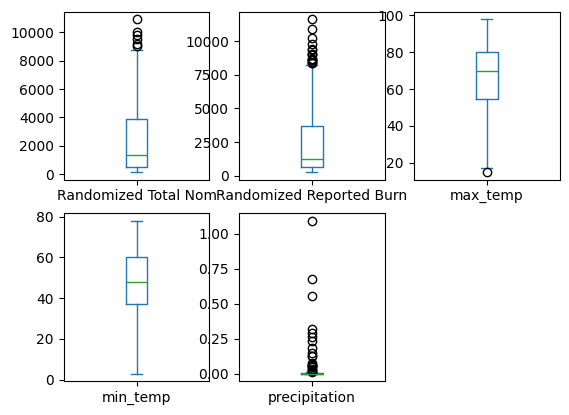

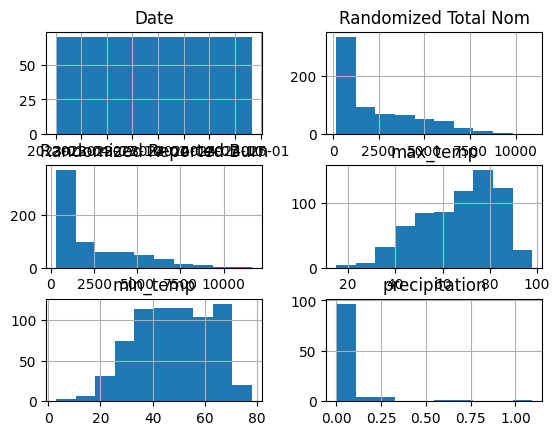

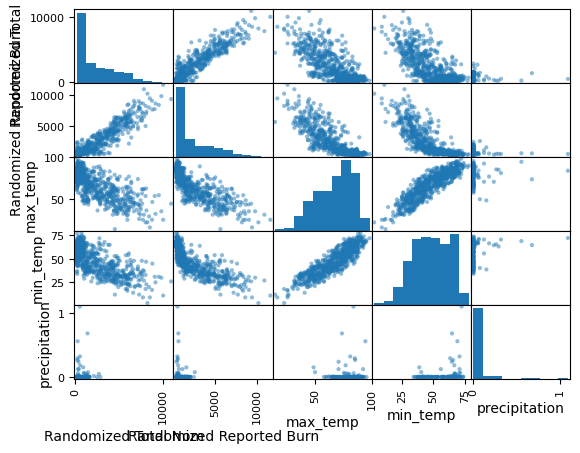

In [80]:
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

#Box and Whisker Plots
df.plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False)

#Histograms
df.hist()

#Scatter matrix
scatter_matrix(df)
plt.show()